In [39]:
from __future__ import print_function
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse
import random
import torchvision.transforms.functional as TF

from torchvision.utils import save_image
from skimage.util import random_noise
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
import kornia.augmentation.functional as FF
import statistics 

In [2]:
root = "./"
def default_loader(path):
    return Image.open(path).convert('RGB')

In [3]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self,root, datatxt, transform=None, target_transform=None,loader=default_loader):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r') 
        imgs = []     
        data = []
        label = []
        for line in fh:                
            line = line.rstrip()       
            data.append(line)
        for line in range(len(data)-1):
            words = data[line].split()  
            imgs.append((words[0])) 
            label.append(int(words[1]))
            
        
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.label = torch.LongTensor(label)
 
    # def __getitem__(self, index):    
    def __getitem__(self, idx):    
        image = Image.open(str(self.imgs[idx]))
        # image = image.convert('RGB')
        image = image.convert('L')
        if self.transform is not None:
            image = self.transform(image)
        label = self.label[idx]
        return image, label
    def __len__(self): 
        return len(self.imgs)

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
train_dataset = MyDataset(root='./',datatxt='train.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
trainNew_dataset = MyDataset(root='./',datatxt='train-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
test_dataset = MyDataset(root='./',datatxt='test.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
testNew_dataset = MyDataset(root='./',datatxt='test-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
origin_dataset = MyDataset(root='./',datatxt='origin.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=1)
trainNew_loader = DataLoader(dataset=trainNew_dataset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False,num_workers=1)
testNew_loader = DataLoader(dataset=testNew_dataset, batch_size=64, shuffle=False,num_workers=1)
origin_loader = DataLoader(dataset=origin_dataset, batch_size=64, shuffle=False,num_workers=1)
print('num_of_trainData:', len(train_dataset))
print('num_of_trainNewData:', len(trainNew_dataset))
print('num_of_testData:', len(test_dataset))
print('num_of_testNewData:', len(testNew_dataset))
print('num_of_originData:', len(origin_dataset))

num_of_trainData: 71432
num_of_trainNewData: 89827
num_of_testData: 8141
num_of_testNewData: 10299
num_of_originData: 8141


label： tensor(0) shape: (1, 19, 19)
<class 'numpy.ndarray'>


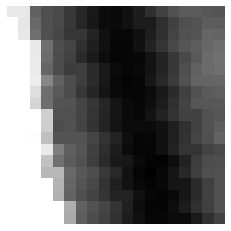

In [6]:
import matplotlib
idx = 11
img = test_dataset[idx][0].numpy()
plt.imshow(img[0], cmap = 'gray')
plt.imsave('test.png', img[0], cmap = 'gray')
# figure, b = plt.subplots()
# figure.set_size_inches(0.19, 0.19)
plt.axis('off') 
print('label：',train_dataset[idx][1], 'shape:', img.shape)
print(type(img[0]))
matplotlib.image.imsave('name.png',img[0])

In [7]:
positive = 0
negative = 0
for idx in range(1,71432):
    if train_dataset[idx][1].item() == 0:
        negative = negative+1
    else:
        positive = positive+1
print('negative: ', negative)
print('positive: ', positive)

KeyboardInterrupt: 

In [9]:
class GaborConvPC(nn.Module):
#     def __init__(self, kernel_size, in_channels, num_orientations, num_scales):
#         super(GaborConvPC, self).__init__()
#         self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, self.bias1, self.weights1, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
#         self.sigma2, self.theta2, self.Lambda2, self.psi2, self.gamma2, self.bias2, self.weights2, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
#         # self.filter1 = self.whole_filter(in_channels, channel1, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1)
#         self.filter_cos = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, True)
#         self.filter_sin = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, False)       
        
#         self.fc1 = nn.Linear(1*1*48, 24)
#         self.fc2 = nn.Linear(24, 2)



#     def forward(self, x):
#         x_cos = F.conv2d(x, self.filter_cos, bias=self.bias1)
#         x_sin = F.conv2d(x, self.filter_sin, bias=self.bias2)
#         x_comb = torch.cat((x_cos, x_sin), 2)

#         x_cos = x_cos.view(len(x), 1, 1, 48)
#         x_sin = x_sin.view(len(x), 1, 1, 48)
#         weighted_cos = (torch.matmul(x_cos, self.weights1)).view(len(x), 1)
#         weighted_sin = (torch.matmul(x_sin, self.weights1)).view(len(x), 1)

#         numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
# #         print("numerator", numerator.size())
#         x_comb_norm = torch.norm(x_comb, dim=2)
#         x_comb_norm = x_comb_norm.view(len(x), 1, 48)
# #         print("x_comb_norm", x_comb_norm.size())
#         denominator = torch.matmul(x_comb_norm, torch.abs(self.weights1))
#         denominator = denominator.view(len(x))

#         pc = numerator / denominator                
#         return torch.sigmoid(self.w * pc + self.b)


#     def generate_parameters(self, dim_out, dim_in):
#         sigma = nn.Parameter(torch.randn(1, 1))
#         theta = nn.Parameter(torch.randn(1, 1))
#         Lambda = nn.Parameter(torch.randn(1, 1))
#         psi = nn.Parameter(torch.randn(1, 1))
#         gamma = nn.Parameter(torch.randn(1, 1))
#         bias = nn.Parameter(torch.randn(dim_out))
#         weights = nn.Parameter(torch.randn(1, 48, 1))
#         w = nn.Parameter(torch.randn(1, 1))
#         b = nn.Parameter(torch.randn(1, 1))
#         return sigma, theta, Lambda, psi, gamma, bias, weights, w, b
    def __init__(self, kernel_size, in_channels, num_orientations, num_scales):
        super(GaborConvPC, self).__init__()
        self.sigma, self.theta, self.Lambda, self.psi, self.gamma, self.bias1, self.bias2, self.weights, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
        self.filter_cos = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma, self.theta, self.Lambda, self.psi, self.gamma, True)
        self.filter_sin = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma, self.theta, self.Lambda, self.psi, self.gamma, False)

        self.fc1 = nn.Linear(1*1*48, 24)
        self.fc2 = nn.Linear(24, 2)


    def forward(self, x):
        x_cos = F.conv2d(x, self.filter_cos, bias=self.bias1)
        x_sin = F.conv2d(x, self.filter_sin, bias=self.bias2)
        x_comb = torch.cat((x_cos, x_sin), 2)
        x_cos = x_cos.view(len(x), 1, 1, 48)
        x_sin = x_sin.view(len(x), 1, 1, 48)
        weighted_cos = (torch.matmul(x_cos, self.weights)).view(len(x), 1)
        weighted_sin = (torch.matmul(x_sin, self.weights)).view(len(x), 1)

        numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
        x_comb_norm = torch.norm(x_comb, dim=2)
        x_comb_norm = x_comb_norm.view(len(x), 1, 48)
        denominator = torch.matmul(x_comb_norm, torch.abs(self.weights))
        denominator = denominator.view(len(x))
        pc = numerator / denominator                
        return torch.sigmoid(self.w * pc + self.b),pc


    def generate_parameters(self, dim_out, dim_in):
        sigma = nn.Parameter(torch.randn(1, 1))
        theta = nn.Parameter(torch.randn(1, 1))
        Lambda = nn.Parameter(torch.randn(1, 1))
        psi = nn.Parameter(torch.randn(1, 1))
        gamma = nn.Parameter(torch.randn(1, 1))
        bias1 = nn.Parameter(torch.randn(dim_out))
        bias2 = nn.Parameter(torch.randn(dim_out))
        weights = nn.Parameter(torch.randn(1, 48, 1))
        w = nn.Parameter(torch.randn(1, 1))
        b = nn.Parameter(torch.randn(1, 1))
        return sigma, theta, Lambda, psi, gamma, bias1, bias2, weights, w, b


    def whole_filter(self, in_channels, num_orientations, num_scales, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(num_orientations*num_scales, in_channels, kernel_size, kernel_size) # \text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW
        for i in range(num_orientations):
            for j in range(num_scales):
                result[i*num_scales + j] = self.one_filter(in_channels, kernel_size, sigma[0]*(2.1**j), theta[0]+i*np.pi/num_orientations, Lambda[0], psi[0], gamma[0], cos)
        return nn.Parameter(result)


    def one_filter(self, in_channels, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(in_channels, kernel_size, kernel_size)
        for i in range(in_channels):
            result[i] = self.gabor_fn(sigma, theta, Lambda, psi, gamma, kernel_size, cos)
        return nn.Parameter(result)


    def gabor_fn(self, sigma, theta, Lambda, psi, gamma, kernel_size, cos):
        sigma_x = sigma
        # sigma_y = float(sigma) / gamma
        sigma_y = sigma / gamma

        # Bounding box
        half_size = (kernel_size - 1) // 2
        ymin, xmin = -half_size, -half_size
        ymax, xmax = half_size, half_size
    #     (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
        y, x = torch.meshgrid([torch.arange(ymin, ymax+1), torch.arange(xmin,xmax+1)])

        if cos:
            gb = torch.exp(-.5 * (x**2 / sigma_x**2 + y**2 / sigma_y**2)) * torch.cos(2 * np.pi / Lambda * x + psi)
        else:
            gb = torch.exp(-.5 * (x**2 / sigma_x**2 + y**2 / sigma_y**2)) * torch.sin(2 * np.pi / Lambda * x + psi)

        # Rotation
        degrees = theta * 180 / np.pi
        gb = FF.apply_rotation(gb, {'degrees': torch.tensor(degrees)}, {'interpolation': torch.tensor([1]), 'align_corners': torch.tensor(True)})
        gb = gb.squeeze()
        return gb


<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([48])
<class 'torch.Tensor'> torch.Size([48])
<class 'torch.Tensor'> torch.Size([1, 48, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([48, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([48, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([24, 48])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([2, 24])
<class 'torch.Tensor'> torch.Size([2])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Epoch: 1 [0/71432 (0%)]	Loss: 48.603153
Train Epoch: 1 [6400/71432 (9%)]	Loss: 35.009838
Train Epoch: 1 [12800/71432 (18%)]	Loss: 20.915850
Train Epoch: 1 [19200/71432 (27%)]	Loss: 18.323053
Train Epoch: 1 [25600/71432 (36%)]	Loss: 14.125262
Train Epoch: 1 [32000/71432 (45%)]	Loss: 12.656539
Train Epoch: 1 [38400/71432 (54%)]	Loss: 17.845667
Train Epoch: 1 [44800/71432 (63%)]	Loss: 16.184490
Train Epoch: 1 [51200/71432 (72%)]	Loss: 18.283365
Train Epoch: 1 [57600/71432 (81%)]	Loss: 15.357291
Train Epoch: 1 [64000/71432 (90%)]	Loss: 9.544128
Train Epoch: 1 [70400/71432 (98%)]	Loss: 12.535745

Test set: Average loss: 0.2239, Accuracy: 7435/8141 (91%), Positive accuracy: 3558/4091 (87%), Negative accuracy: 3877/4050 (96%), train loss: 0.3036

Train Epoch: 2 [0/71432 (0%)]	Loss: 14.142234
Train Epoch: 2 [6400/71432 (9%)]	Loss: 17.528366
Train Epoch: 2 [12800/71432 (18%)]	Loss: 19.495396
Train Epoch: 2 [19200/71432 (27%)]	Loss: 20.777678
Train Epoch: 2 [25600/71432 (36%)]	Loss: 9.9791

Train Epoch: 12 [0/71432 (0%)]	Loss: 7.344242
Train Epoch: 12 [6400/71432 (9%)]	Loss: 15.782540
Train Epoch: 12 [12800/71432 (18%)]	Loss: 9.478770
Train Epoch: 12 [19200/71432 (27%)]	Loss: 15.699148
Train Epoch: 12 [25600/71432 (36%)]	Loss: 19.821827
Train Epoch: 12 [32000/71432 (45%)]	Loss: 9.793143
Train Epoch: 12 [38400/71432 (54%)]	Loss: 10.953063
Train Epoch: 12 [44800/71432 (63%)]	Loss: 7.606368
Train Epoch: 12 [51200/71432 (72%)]	Loss: 11.750005
Train Epoch: 12 [57600/71432 (81%)]	Loss: 13.582916
Train Epoch: 12 [64000/71432 (90%)]	Loss: 6.380159
Train Epoch: 12 [70400/71432 (98%)]	Loss: 15.152920

Test set: Average loss: 0.2355, Accuracy: 7374/8141 (91%), Positive accuracy: 3474/4091 (85%), Negative accuracy: 3900/4050 (96%), train loss: 0.1692

Train Epoch: 13 [0/71432 (0%)]	Loss: 10.149737
Train Epoch: 13 [6400/71432 (9%)]	Loss: 10.663799
Train Epoch: 13 [12800/71432 (18%)]	Loss: 9.421299
Train Epoch: 13 [19200/71432 (27%)]	Loss: 16.689062
Train Epoch: 13 [25600/71432 (36%)]	

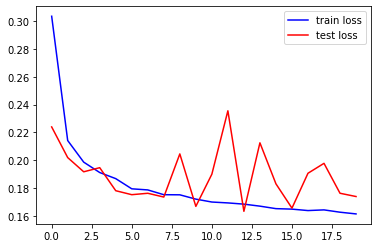

In [44]:
def myLoss(output, target):
#     print("size,size:",output.size(), target.size())
#     print("size,", ((1-2*target) * torch.log(output)).size())
#     return -torch.sum(target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)
    return -torch.sum((36885/34546)*target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)[0]
#         loss = F.nll_loss(output, target)
        loss = myLoss(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_list.append(loss.item()/64)
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss = sum(loss_list)/len(loss_list)
    return train_loss

        
def test(args, model, device, test_loader,count,epoch,train_loss):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    correct_pc_true0 = []
    correct_pc_true1 = []
    wrong_pc_true0 = []
    wrong_pc_true1 = []
    with torch.no_grad():
        for batch_idx,(data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)[0]
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += myLoss(output, target)
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            t = Variable(torch.Tensor([0.5]))
            pred = (output > t) * 1
            pred = torch.reshape(pred, (len(target), 1))
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
             # Store wrongly predicted images
            if epoch == 16:
                num = 0
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                true_idx = (pred == target.view_as(pred)).nonzero()[:, 0]
                true_samples = data[true_idx]
                true_preds = pred[true_idx]
                for i in range(len(true_idx)):
                    true_pred = true_preds[i]
                    if true_pred.item() == 0:
                        correct_pc_true0.append(model(data)[1][true_idx[i]].item())
                    else:
                        correct_pc_true1.append(model(data)[1][true_idx[i]].item())
                        
                for i in range(len(wrong_idx)):
                    actual_pred = actual_preds[i]
                    if actual_pred.item() == 0:
                        wrong_pc_true0.append(model(data)[1][wrong_idx[i]].item())
                    else:
                        wrong_pc_true1.append(model(data)[1][wrong_idx[i]].item())
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    # Undo normalization
            #         sample = sample * 0.3081
            #         sample = sample + 0.1307
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    num = num + 1
                    img.save('./wrong-gabor/{}_true{}_pc{:.4f}.png'.format(
                    batch_idx*64+num, actual_pred.item(),model(data)[1][wrong_idx[i]].item()))
                    
    #                 print(batch_idx,wrong_idx[i])
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-gabor/{}_true{}__pc{:.4f}_ori.png'.format(
                    batch_idx*64+num, actual_pred.item(), model(data)[1][wrong_idx[i]].item()),img_ori[0], cmap = 'gray')
                    
            
                
                    
                
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), train loss: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),train_loss))
    if len(correct_pc_true0) != 0:
        print('\ncorrect_0: mean: {:.4f}, std: {:.4f}'.format(statistics.mean(correct_pc_true0),statistics.pstdev(correct_pc_true0)))
        print('\ncorrect_1: mean: {:.4f}, std: {:.4f}'.format(statistics.mean(correct_pc_true1),statistics.pstdev(correct_pc_true1)))
        print('\nwrong_0: mean: {:.4f}, std: {:.4f}'.format(statistics.mean(wrong_pc_true0), statistics.pstdev(wrong_pc_true0)))
        print('\nwrong_1: mean: {:.4f}, std: {:.4f}'.format(statistics.mean(wrong_pc_true1), statistics.pstdev(wrong_pc_true1)))
    return test_loss, correct
    

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    parser.add_argument('--std', type=float, default=0, metavar='STD',
                        help='noise-std (default: 0)')
    parser.add_argument('--mean', type=float, default=0, metavar='MEAN',
                        help='noise-std (default: 0)')
#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])
    model = GaborConvPC(19, 1, 8, 6).to(device)
    # if torch.cuda.is_available():
    #     torch.set_default_tensor_type('torch.cuda.FloatTensor')
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    count = 0
    for param in model.parameters():
        print(type(param.data), param.size())
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    for epoch in range(1, args.epochs + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss_list.append(train_loss)
        test_result = test(args, model, device, test_loader,count,epoch,train_loss)
        test_loss_list.append(test_result[0])
        test_accuracy_list.append(test_result[1])
        # for param in model.parameters():
        #     print(param.size(), param.data)
        # print(model.state_dict())
        



    if (args.save_model):
        torch.save(model.state_dict(),"pretrain_gabor.pt")
    plt.plot(train_loss_list, color='blue',label='train loss')  
    plt.plot(test_loss_list, color='red',label='test loss')  
    plt.legend()
    print(test_accuracy_list)

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/71432 (0%)]	Loss: 0.692208
Train Epoch: 1 [6400/71432 (9%)]	Loss: 0.681850
Train Epoch: 1 [12800/71432 (18%)]	Loss: 0.620283
Train Epoch: 1 [19200/71432 (27%)]	Loss: 0.434132
Train Epoch: 1 [25600/71432 (36%)]	Loss: 0.380064
Train Epoch: 1 [32000/71432 (45%)]	Loss: 0.387745
Train Epoch: 1 [38400/71432 (54%)]	Loss: 0.371992
Train Epoch: 1 [44800/71432 (63%)]	Loss: 0.411371
Train Epoch: 1 [51200/71432 (72%)]	Loss: 0.384105
Train Epoch: 1 [57600/71432 (81%)]	Loss: 0.270502
Train Epoch: 1 [64000/71432 (90%)]	Loss: 0.394748
Train Epoch: 1 [70400/71432 (98%)]	Loss: 0.372798

Test set: Average loss: 0.2699, Accuracy: 7186/8141 (88%), Positive accuracy: 3743/4091 (91%), Negative accuracy: 3443/4050 (85%), f1 score: 0.8837, Train loss: 0.4389

Train Epoch: 2 [0/71432 (0%)]	Loss: 0.243357
Train Epoch: 2 [6400/71432 (9%)]	Loss: 0.303426
Train Epoch: 2 [12800/71432 (18%)]	Loss: 0.293365
Train Epoch: 2 [19200/71432 (27%)]	Loss: 0.222958
Train Epoch: 2 [25600/71432 (36%)]	Loss: 0.2

Train Epoch: 11 [70400/71432 (98%)]	Loss: 0.150002

Test set: Average loss: 0.1182, Accuracy: 7753/8141 (95%), Positive accuracy: 3876/4091 (95%), Negative accuracy: 3877/4050 (96%), f1 score: 0.9523, Train loss: 0.1366

Train Epoch: 12 [0/71432 (0%)]	Loss: 0.095757
Train Epoch: 12 [6400/71432 (9%)]	Loss: 0.087062
Train Epoch: 12 [12800/71432 (18%)]	Loss: 0.054357
Train Epoch: 12 [19200/71432 (27%)]	Loss: 0.178713
Train Epoch: 12 [25600/71432 (36%)]	Loss: 0.216402
Train Epoch: 12 [32000/71432 (45%)]	Loss: 0.073902
Train Epoch: 12 [38400/71432 (54%)]	Loss: 0.141404
Train Epoch: 12 [44800/71432 (63%)]	Loss: 0.185083
Train Epoch: 12 [51200/71432 (72%)]	Loss: 0.179244
Train Epoch: 12 [57600/71432 (81%)]	Loss: 0.098940
Train Epoch: 12 [64000/71432 (90%)]	Loss: 0.151811
Train Epoch: 12 [70400/71432 (98%)]	Loss: 0.073463

Test set: Average loss: 0.1192, Accuracy: 7746/8141 (95%), Positive accuracy: 3861/4091 (94%), Negative accuracy: 3885/4050 (96%), f1 score: 0.9515, Train loss: 0.1364

Trai

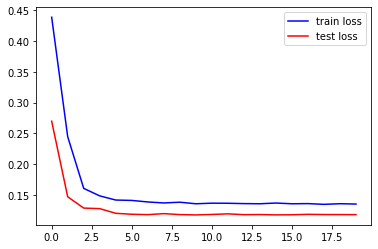

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6400, 1024)
        self.fc2 = nn.Linear(1024, 2)
#         self.fc3 = nn.Linear(128, 2)
#         self.conv1 = nn.Conv2d(1, 16, 3, 1)
#         self.conv2 = nn.Conv2d(16, 32, 3, 1)
#         self.conv3 = nn.Conv2d(32, 64, 3, 1)
# #         self.conv4 = nn.Conv2d(64, 128, 3, 1)
# #         self.conv5 = nn.Conv2d(128, 256, 3, 1)
#         # self.fc1 = nn.Linear(9216, 128)
# #         self.fc2 = nn.Linear(128, 2)
#         self.fc1 = nn.Linear(2304, 1024)
#         self.fc2 = nn.Linear(1024, 128)
#         self.fc3 = nn.Linear(128, 2)
# #         self.fc4 = nn.Linear(256, 64)
# # #         self.fc5 = nn.Linear(64, 16)
# # #         self.fc6 = nn.Linear(16, 6)
# #         self.fc5 = nn.Linear(64, 2)



    def forward(self, x_ori):
        x = self.conv1(x_ori)
        conv1 = F.relu(x)  #store conv1
        conv2 = self.conv2(conv1)
        conv2 = F.relu(conv2) #store conv2
#         x = F.max_pool2d(conv2, 2)
        conv3 = self.conv3(conv2)
        conv3 = F.relu(conv3) #store conv2
        conv4 = self.conv4(conv3)
        conv4 = F.relu(conv4) #store conv2
        x = F.max_pool2d(conv4, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
#         x = F.relu(x)
#         x = self.dropout3(x)
#         x = self.fc3(x)
#         x = self.conv1(x_ori)
#         conv1 = F.relu(x)  #store conv1
#         conv2 = self.conv2(conv1)
#         conv2 = F.relu(conv2) #store conv2
#         conv3 = self.conv3(conv2)
#         conv3 = F.relu(conv3) #store conv2
# #         conv4 = self.conv4(conv3)
# #         conv4 = F.relu(conv4) #store conv2
# #         conv5 = self.conv5(conv4)
# #         conv5 = F.relu(conv5) #store conv2
#         x = F.max_pool2d(conv3, 2)
# #         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
# #         x = self.dropout2(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
# #         x = F.relu(x)
# #         x = self.fc4(x)
# #         x = F.relu(x)
# # #         x = self.fc5(x)
# # #         x = F.relu(x)
# # #         x = self.fc6(x)
# # #         x = F.relu(x)
# #         x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    num = 0
    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        weight = torch.tensor([34546/(36885+34546),36885/(36885+34546)])
        loss = F.nll_loss(output, target, weight = weight)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
#         if epoch == 3 and batch_idx == 10:
#             for i in range(64):
#                 img_ori = output[1][i].numpy()
#                 real = target[i].detach().numpy()
#                 predict = output[0][i].detach().numpy()
#                 plt.imsave('./CNN/real{}_{}_a.png'.format(real,num),img_ori[0],cmap = 'gray')
#                 img_conv1 = output[2][i].detach().numpy()
#                 for j in range(len(img_conv1)):
#                     plt.imsave('./CNN/real{}_{}_conv1_{}.png'.format(real, num, j),img_conv1[0],cmap = 'gray')
#                 img_conv2 = output[3][i].detach().numpy()
#                 for k in range(len(img_conv2)):
#                     plt.imsave('./CNN/real{}_{}_conv2_{}.png'.format(real,num,k),img_conv2[0],cmap = 'gray')
#                 num = num+1
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

            if args.dry_run:
                break
    train_loss = sum(loss_list)/len(loss_list)
    return train_loss
                


def test(model, device, test_loader,count,epoch,train_loss):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
            
            if epoch == 13:
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                for i in range(len(wrong_idx)):
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    # Undo normalization
            #         sample = sample * 0.3081
            #         sample = sample + 0.1307
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    count = count+1
                    img.save('./wrong-cnn/batch{}_i{}_actual{}.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item()))
                    num = batch_idx * 64 + wrong_idx[i]
    #                 print(batch_idx,wrong_idx[i])
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-cnn/batch{}_i{}_actual{}_ori.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')

    test_loss /= len(test_loader.dataset)
    precision = result[1][1]/(result[1][1]+result[0][1])
    recall = result[0][0]/(result[0][0]+result[1][0])
    f1score = 2*(precision*recall)/(precision+recall)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), f1 score: {:.4f}, Train loss: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),f1score,train_loss))
    return test_loss, correct


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    count = 0
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    for epoch in range(1, args.epochs + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss_list.append(train_loss)
        test_result = test(model, device, test_loader, count, epoch,train_loss)
        test_loss_list.append(test_result[0])
        test_accuracy_list.append(test_result[1])
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
    plt.plot(train_loss_list, color='blue',label='train loss')  
    plt.plot(test_loss_list, color='red',label='test loss')  
    plt.legend()
    print(test_accuracy_list)


if __name__ == '__main__':
    main()

In [14]:

                figure, b = plt.subplots()
                figure.set_size_inches(19, 19)
                plt.axis('off')
                plt.imshow(model.filter_cos[i].detach().numpy()[0], cmap='gray')
#                 np.savetxt('train-coeff.txt', model.filter_cos[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
#                 img.save('./filter/{}_ori_{}scale_{}.png'.format('cos',ori,scale))
                si = model.sigma1.detach().numpy()*(2.1**scale)
                de = model.theta1.detach().numpy()+ori*np.pi/8
                plt.savefig("./filter-11.3_9/%s_scale_%.2fdeg_%.2f.png" % ('cos',si,de), dpi=1,pad_inches=0.0,bbox_inches='tight')
                if scale == 5:
                    scale = 0
                    ori = ori+1
                else:
                    scale = scale + 1

            scale = 0
            ori = 0
            for i in range(len(model.filter_sin)):
#                 sample = model.filter_sin[i]
#                 sample = sample * 255.
#                 sample = sample.byte()
#                 img = TF.to_pil_image(sample)
                figure, b = plt.subplots()
                figure.set_size_inches(0.19, 0.19)
                plt.axis('off')
                plt.imshow(model.filter_sin[i].detach().numpy()[0], cmap='gray')
#                 np.savetxt('train-coeff.txt', model.filter_sin[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
                si = model.sigma1.detach().numpy()*(2.1**scale)
                de = model.theta1.detach().numpy()+ori*np.pi/8
#                 img.save('./filter/{}_ori_{}scale_{}.png'.ormat('sin',ori,scale))
                plt.savefig("./filter-11.3_9/%s_scale_%.2fdeg_%.2f.png" % ('sin',si,de), dpi=100,pad_inches=0.0,bbox_inches='tight')
                if scale == 5:
                    scale = 0
                    ori = ori + 1
                else:
                    scale = scale + 1

IndentationError: unexpected indent (<ipython-input-14-d90b47fe309a>, line 16)

In [46]:
pretrain_gabor_model = torch.load('pretrain_gabor.pt')
filter_cos = pretrain_gabor_model['filter_cos']
filter_sin = pretrain_gabor_model['filter_sin']
bias1 = pretrain_gabor_model['bias1']
bias2 = pretrain_gabor_model['bias2']
weights = pretrain_gabor_model['weights']
w = pretrain_gabor_model['w']
b = pretrain_gabor_model['b']
print(w)
print(weights)

tensor([[-15.2498]])
tensor([[[ 1.7825e+00],
         [ 1.0330e+00],
         [ 9.2251e-01],
         [ 1.0068e+00],
         [ 1.2314e-01],
         [-1.1066e-02],
         [ 1.6262e+00],
         [ 1.3829e+00],
         [-1.8511e+00],
         [-1.3031e+00],
         [ 1.6012e+00],
         [ 2.4274e+00],
         [ 2.9228e+00],
         [ 1.7475e-03],
         [-2.2883e+00],
         [ 1.7760e+00],
         [ 3.7275e-01],
         [ 9.1276e-03],
         [ 1.8626e-01],
         [ 1.3131e+00],
         [ 2.4674e+00],
         [-1.5379e+00],
         [ 8.9394e-03],
         [ 3.4271e-01],
         [-1.9210e+00],
         [-1.0494e+00],
         [-4.0725e-03],
         [-2.0297e+00],
         [-4.9918e-02],
         [-2.9350e-01],
         [ 9.6965e-01],
         [ 1.4379e+00],
         [ 9.0205e-01],
         [ 5.8989e-01],
         [ 1.9992e-05],
         [ 1.1629e+00],
         [-1.9780e+00],
         [-8.0132e-01],
         [ 2.1986e+00],
         [ 5.4490e-01],
         [-2.4459e-

In [8]:
def pc(x): #x as a picture
    x_cos = F.conv2d(x, filter_cos, bias=bias1)
    x_sin = F.conv2d(x, filter_sin, bias=bias2)
    x_comb = torch.cat((x_cos, x_sin), 2)

    x_cos = x_cos.view(len(x), 1, 1, 24)
    x_sin = x_sin.view(len(x), 1, 1, 24)
    weighted_cos = (torch.matmul(x_cos, weights)).view(len(x), 1)
    weighted_sin = (torch.matmul(x_sin, weights)).view(len(x), 1)

    numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
#         print("numerator", numerator.size())
    x_comb_norm = torch.norm(x_comb, dim=2)
    x_comb_norm = x_comb_norm.view(len(x), 1, 24)
#         print("x_comb_norm", x_comb_norm.size())
    denominator = torch.matmul(x_comb_norm, torch.abs(weights))
    denominator = denominator.view(len(x))
#         print("size:", numerator.size(), denominator.size())
    pc = numerator / denominator                
#     return torch.sigmoid(w * pc + b)
    return pc

Train Epoch: 1 [0/71432 (0%)]	Loss: 0.628911
Train Epoch: 1 [6400/71432 (9%)]	Loss: 0.295053
Train Epoch: 1 [12800/71432 (18%)]	Loss: 0.262737
Train Epoch: 1 [19200/71432 (27%)]	Loss: 0.184690
Train Epoch: 1 [25600/71432 (36%)]	Loss: 0.136053
Train Epoch: 1 [32000/71432 (45%)]	Loss: 0.114957
Train Epoch: 1 [38400/71432 (54%)]	Loss: 0.085034
Train Epoch: 1 [44800/71432 (63%)]	Loss: 0.084477
Train Epoch: 1 [51200/71432 (72%)]	Loss: 0.152466
Train Epoch: 1 [57600/71432 (81%)]	Loss: 0.074285
Train Epoch: 1 [64000/71432 (90%)]	Loss: 0.152649
Train Epoch: 1 [70400/71432 (98%)]	Loss: 0.175278

Test set: Average loss: 0.1372, Accuracy: 7698/8141 (95%), Positive accuracy: 3737/4091 (91%), Negative accuracy: 3961/4050 (98%), f1 score: 0.9464

Train Epoch: 2 [0/71432 (0%)]	Loss: 0.093958
Train Epoch: 2 [6400/71432 (9%)]	Loss: 0.198442
Train Epoch: 2 [12800/71432 (18%)]	Loss: 0.119478
Train Epoch: 2 [19200/71432 (27%)]	Loss: 0.054716
Train Epoch: 2 [25600/71432 (36%)]	Loss: 0.035890
Train Epoch: 2

Train Epoch: 12 [0/71432 (0%)]	Loss: 0.083781
Train Epoch: 12 [6400/71432 (9%)]	Loss: 0.094759
Train Epoch: 12 [12800/71432 (18%)]	Loss: 0.058378
Train Epoch: 12 [19200/71432 (27%)]	Loss: 0.080779
Train Epoch: 12 [25600/71432 (36%)]	Loss: 0.067572
Train Epoch: 12 [32000/71432 (45%)]	Loss: 0.132605
Train Epoch: 12 [38400/71432 (54%)]	Loss: 0.112927
Train Epoch: 12 [44800/71432 (63%)]	Loss: 0.069503
Train Epoch: 12 [51200/71432 (72%)]	Loss: 0.078576
Train Epoch: 12 [57600/71432 (81%)]	Loss: 0.150780
Train Epoch: 12 [64000/71432 (90%)]	Loss: 0.130739
Train Epoch: 12 [70400/71432 (98%)]	Loss: 0.043161

Test set: Average loss: 0.0995, Accuracy: 7814/8141 (96%), Positive accuracy: 3884/4091 (95%), Negative accuracy: 3930/4050 (97%), f1 score: 0.9599

Train Epoch: 13 [0/71432 (0%)]	Loss: 0.122115
Train Epoch: 13 [6400/71432 (9%)]	Loss: 0.129866
Train Epoch: 13 [12800/71432 (18%)]	Loss: 0.059112
Train Epoch: 13 [19200/71432 (27%)]	Loss: 0.114963
Train Epoch: 13 [25600/71432 (36%)]	Loss: 0.1068

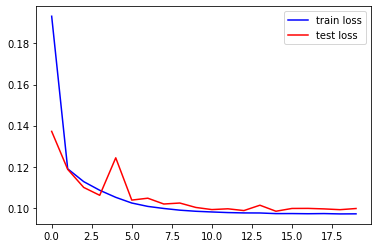

In [11]:

class CNNTrainedGabor(nn.Module):
    def __init__(self, pretrain_gabor_model):
        super(CNNTrainedGabor, self).__init__()
        self.pretrain_gabor_model = pretrain_gabor_model
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.conv2 = nn.Conv2d(4, 8, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
        # self.fc1 = nn.Linear(9216, 128)
        self.fc1 = nn.Linear(72,15)
#         self.fc2 = nn.Linear(128, 2)
        
        self.fc2 = nn.Linear(16, 2)
   
    def forward(self, x):
        pc = self.pc(x).view(x.shape[0],1)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        x = F.relu(x)

#         x = self.dropout2(x)
#         print(pc.shape, x.shape)
        x = torch.cat((pc, x), 1)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def pc(self, x):
        filter_cos = self.pretrain_gabor_model['filter_cos']
        filter_sin = self.pretrain_gabor_model['filter_sin']
        bias1 = self.pretrain_gabor_model['bias1']
        bias2 = self.pretrain_gabor_model['bias2']
        weights = self.pretrain_gabor_model['weights']
        w = self.pretrain_gabor_model['w']
        b = self.pretrain_gabor_model['b']
        
        x_cos = F.conv2d(x, filter_cos, bias=bias1)
        x_sin = F.conv2d(x, filter_sin, bias=bias2)
        x_comb = torch.cat((x_cos, x_sin), 2)

        x_cos = x_cos.view(len(x), 1, 1, 48)
        x_sin = x_sin.view(len(x), 1, 1, 48)
        weighted_cos = (torch.matmul(x_cos, weights)).view(len(x), 1)
        weighted_sin = (torch.matmul(x_sin, weights)).view(len(x), 1)

        numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
    #         print("numerator", numerator.size())
        x_comb_norm = torch.norm(x_comb, dim=2)
        x_comb_norm = x_comb_norm.view(len(x), 1, 48)
    #         print("x_comb_norm", x_comb_norm.size())
        denominator = torch.matmul(x_comb_norm, torch.abs(weights))
        denominator = denominator.view(len(x))
    #         print("size:", numerator.size(), denominator.size())
        pc = numerator / denominator                
        return torch.sigmoid(w * pc + b)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
    train_loss = sum(loss_list)/len(loss_list)
    return train_loss


# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
def test(model, device, test_loader,epoch,train_loss):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
            
            # Store wrongly predicted images
            if epoch == 7:
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                for i in range(len(wrong_idx)):
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    img.save('./wrong-mix/epoch{}_batch{}_idx{}_actual{}.png'.format(
                        epoch,batch_idx,wrong_idx[i], actual_pred.item()))
                    num = batch_idx * 64 + wrong_idx[i]
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-mix/epoch{}_batch{}_idx{}_actual{}_ori.png'.format(
                    epoch,batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')

    test_loss /= len(test_loader.dataset)
    precision = result[1][1]/(result[1][1]+result[0][1])
    recall = result[0][0]/(result[0][0]+result[1][0])
    f1score = 2*(precision*recall)/(precision+recall)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), f1 score: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),f1score))
    return test_loss, correct


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=100, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    model = CNNTrainedGabor(pretrain_gabor_model).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    for epoch in range(1, args.epochs + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss_list.append(train_loss)
        test_result = test(model, device, test_loader,epoch,train_loss)
        test_loss_list.append(test_result[0])
        test_accuracy_list.append(test_result[1])
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    plt.plot(train_loss_list, color='blue',label='train loss')  
    plt.plot(test_loss_list, color='red',label='test loss')  
    plt.legend()
    print(test_accuracy_list)



if __name__ == '__main__':
    main()

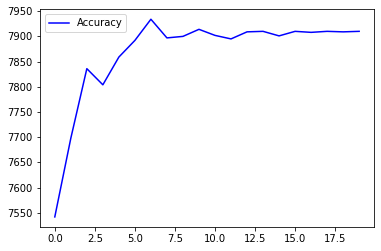

In [26]:
x = [7542, 7698, 7836, 7804, 7859, 7892, 7934, 7897, 7900, 7914, 7902, 7895, 7909, 7910, 7901, 7910, 7908, 7910, 7909, 7910]
plt.plot(x, color='blue',label='Accuracy')  
plt.legend()

Train Epoch: 1 [0/71432 (0%)]	Loss: 0.723132
Train Epoch: 1 [6400/71432 (9%)]	Loss: 0.181368
Train Epoch: 1 [12800/71432 (18%)]	Loss: 0.164086
Train Epoch: 1 [19200/71432 (27%)]	Loss: 0.299986
Train Epoch: 1 [25600/71432 (36%)]	Loss: 0.116206
Train Epoch: 1 [32000/71432 (45%)]	Loss: 0.142081
Train Epoch: 1 [38400/71432 (54%)]	Loss: 0.098413
Train Epoch: 1 [44800/71432 (63%)]	Loss: 0.165801
Train Epoch: 1 [51200/71432 (72%)]	Loss: 0.157562
Train Epoch: 1 [57600/71432 (81%)]	Loss: 0.093857
Train Epoch: 1 [64000/71432 (90%)]	Loss: 0.143686
Train Epoch: 1 [70400/71432 (98%)]	Loss: 0.099544

Test set: Average loss: 0.1291, Accuracy: 7689/8141 (94%), Positive accuracy: 3794/4091 (93%), Negative accuracy: 3895/4050 (96%), f1 score: 0.9447

Train Epoch: 2 [0/71432 (0%)]	Loss: 0.172338
Train Epoch: 2 [6400/71432 (9%)]	Loss: 0.093837
Train Epoch: 2 [12800/71432 (18%)]	Loss: 0.047705
Train Epoch: 2 [19200/71432 (27%)]	Loss: 0.102612
Train Epoch: 2 [25600/71432 (36%)]	Loss: 0.120843
Train Epoch: 2

Train Epoch: 12 [0/71432 (0%)]	Loss: 0.067205
Train Epoch: 12 [6400/71432 (9%)]	Loss: 0.158040
Train Epoch: 12 [12800/71432 (18%)]	Loss: 0.067922
Train Epoch: 12 [19200/71432 (27%)]	Loss: 0.045800
Train Epoch: 12 [25600/71432 (36%)]	Loss: 0.114880
Train Epoch: 12 [32000/71432 (45%)]	Loss: 0.177880
Train Epoch: 12 [38400/71432 (54%)]	Loss: 0.051337
Train Epoch: 12 [44800/71432 (63%)]	Loss: 0.042167
Train Epoch: 12 [51200/71432 (72%)]	Loss: 0.074252
Train Epoch: 12 [57600/71432 (81%)]	Loss: 0.121884
Train Epoch: 12 [64000/71432 (90%)]	Loss: 0.085744
Train Epoch: 12 [70400/71432 (98%)]	Loss: 0.107819

Test set: Average loss: 0.0838, Accuracy: 7880/8141 (97%), Positive accuracy: 3920/4091 (96%), Negative accuracy: 3960/4050 (98%), f1 score: 0.9680

Train Epoch: 13 [0/71432 (0%)]	Loss: 0.098931
Train Epoch: 13 [6400/71432 (9%)]	Loss: 0.127376
Train Epoch: 13 [12800/71432 (18%)]	Loss: 0.050912
Train Epoch: 13 [19200/71432 (27%)]	Loss: 0.069185
Train Epoch: 13 [25600/71432 (36%)]	Loss: 0.0302

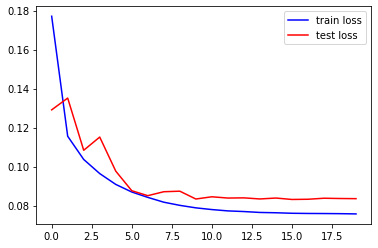

In [38]:
class CNNTrainedGabor(nn.Module):
    def __init__(self, pretrain_gabor_model):
        super(CNNTrainedGabor, self).__init__()
        self.pretrain_gabor_model = pretrain_gabor_model
        self.conv1 = nn.Conv2d(1, 4, 5, 1)
        self.conv2 = nn.Conv2d(4, 8, 5, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
        # self.fc1 = nn.Linear(9216, 128)
        self.fc1 = nn.Linear(225, 128)
#         self.fc2 = nn.Linear(128, 2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 6)
        self.fc5 = nn.Linear(6, 2)
#         self.fc_gabor1 = nn.Linear(96, 36)
#         self.fc_gabor2 = nn.Linear(36, 6)

        
   
    def forward(self, x):
        pc, x_cos, x_sin = self.pc(x)
        pc = pc.view(x.shape[0],1)
#         print(x_cos.shape,x_sin.shape)
        cos, sin = self.mean_std(x_cos,x_sin)
#         print(cos.shape,sin.shape)
        comb = torch.cat((cos,sin,pc),1)
#         x_comb = torch.cat((x_cos, x_sin), 3)
#         x_comb_fc = self.fc_gabor1(x_comb)
#         x_comb_fc = self.fc_gabor2(x_comb_fc)
#         x_comb_fc = torch.squeeze(x_comb_fc)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
# #         x = self.dropout1(x)
        x = torch.flatten(x, 1)
        comb_cnn = torch.cat((comb,x),1)
        x = self.fc1(comb_cnn)

        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)

#         x = self.dropout2(x)
#         print(pc.shape, x.shape)
#         print(x_comb_fc.shape, x.shape)
#         x = torch.cat((x_comb_fc,pc, x), 1)

        output = F.log_softmax(x, dim=1)
        return output
    
    
    def pc(self, x):
        filter_cos = self.pretrain_gabor_model['filter_cos']
        filter_sin = self.pretrain_gabor_model['filter_sin']
        bias1 = self.pretrain_gabor_model['bias1']
        bias2 = self.pretrain_gabor_model['bias2']
        weights = self.pretrain_gabor_model['weights']
        w = self.pretrain_gabor_model['w']
        b = self.pretrain_gabor_model['b']
        
        x_cos = F.conv2d(x, filter_cos, bias=bias1)
        x_sin = F.conv2d(x, filter_sin, bias=bias2)
        x_comb = torch.cat((x_cos, x_sin), 2)

        x_cos = x_cos.view(len(x), 1, 1, 48)
        x_sin = x_sin.view(len(x), 1, 1, 48)
        weighted_cos = (torch.matmul(x_cos, weights)).view(len(x), 1)
        weighted_sin = (torch.matmul(x_sin, weights)).view(len(x), 1)

        numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
    #         print("numerator", numerator.size())
        x_comb_norm = torch.norm(x_comb, dim=2)
        x_comb_norm = x_comb_norm.view(len(x), 1, 48)
    #         print("x_comb_norm", x_comb_norm.size())
        denominator = torch.matmul(x_comb_norm, torch.abs(weights))
        denominator = denominator.view(len(x))
    #         print("size:", numerator.size(), denominator.size())
        pc = numerator / denominator                
        return torch.sigmoid(w * pc + b),x_cos, x_sin
    
    def mean_std(self, x_cos, x_sin):
        cos_mean = torch.FloatTensor([])
        cos_std = torch.FloatTensor([])
        sin_mean = torch.FloatTensor([])
        sin_std = torch.FloatTensor([])
        for i in range(6):
            cos_curr = torch.FloatTensor([])
            sin_curr = torch.FloatTensor([])
            for j in range(i,48,6):
                cos_curr = torch.cat((cos_curr,x_cos[:,:,:,j]),1)
                sin_curr = torch.cat((sin_curr,x_sin[:,:,:,j]),1)
            cos_mean = torch.cat((cos_mean,torch.mean(cos_curr,1)),1)
            cos_std = torch.cat((cos_std,torch.std(cos_curr,1)),1)
            sin_mean = torch.cat((sin_mean,torch.mean(sin_curr,1)),1)
            sin_std = torch.cat((sin_std,torch.std(sin_curr,1)),1)
#         print(cos_mean.shape,cos_std.shape,"mean_std")
        cos = torch.cat((cos_mean,cos_std),1)
        sin = torch.cat((sin_mean,sin_std),1)
        return cos, sin
            


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
    train_loss = sum(loss_list)/len(loss_list)
    return train_loss


# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
def test(model, device, test_loader,epoch,train_loss):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
            
            # Store wrongly predicted images
            if epoch == 11:
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                for i in range(len(wrong_idx)):
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    img.save('./wrong-final/batch{}_idx{}_actual{}.png'.format(
                        batch_idx,wrong_idx[i], actual_pred.item()))
                    num = batch_idx * 64 + wrong_idx[i]
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-final/batch{}_idx{}_actual{}_ori.png'.format(
                        batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')

    test_loss /= len(test_loader.dataset)
    precision = result[1][1]/(result[1][1]+result[0][1])
    recall = result[0][0]/(result[0][0]+result[1][0])
    f1score = 2*(precision*recall)/(precision+recall)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), f1 score: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),f1score))
    return test_loss, correct


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=100, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    model = CNNTrainedGabor(pretrain_gabor_model).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    for epoch in range(1, args.epochs + 1):
        train_loss = train(args, model, device, train_loader, optimizer, epoch)
        train_loss_list.append(train_loss)
        test_result = test(model, device, test_loader,epoch,train_loss)
        test_loss_list.append(test_result[0])
        test_accuracy_list.append(test_result[1])
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    plt.plot(train_loss_list, color='blue',label='train loss')  
    plt.plot(test_loss_list, color='red',label='test loss')  
    plt.legend()
    print(test_accuracy_list)



if __name__ == '__main__':
    main()

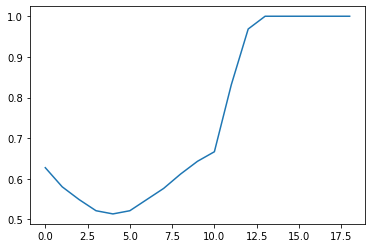

In [14]:
img = plt.imread("./batch27_i55_actual0.png")
change = np.transpose(img)
plt.plot(change[9])